/global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/desipipe_test/AbacusSummit_base_c000_ph000/CutSky/ELG_v5/pypower_abacusHF_DR2_ELG_LOP_z0p950_zcut_0p8to1p6_NGC.npy


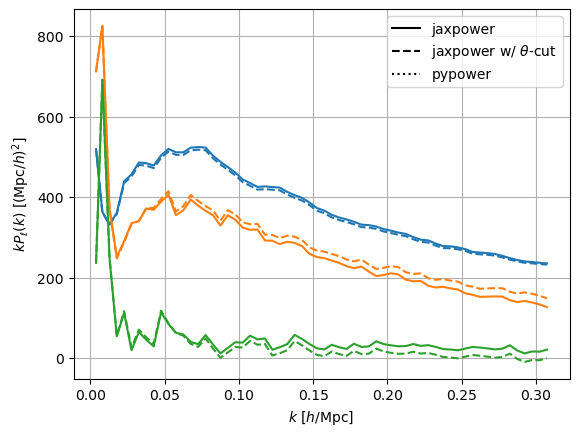

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

from pypower import PowerSpectrumMultipoles
from jaxpower import Spectrum2Poles

from abacus_hf import get_measurement_fn

imock = 0
rebin = 5
catalog_args = dict(region='NGC', tracer='ELG_LOP', zrange=(0.8, 1.1))
print(get_measurement_fn(imock=imock, **catalog_args, kind='pypower'))
#pypower = PowerSpectrumMultipoles.load(get_measurement_fn(imock=imock, region=region, kind='pypower'))
#pypower = pypower[:pypower.shape[0] // rebin * rebin:rebin]
spectrum = Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum')).slice(slice(0, None, rebin))
spectrum_thetacut = Spectrum2Poles.load(get_measurement_fn(imock=imock, **catalog_args, kind='mesh2spectrum_thetacut')).slice(slice(0, None, rebin))

kmin = 0.
ax = plt.gca()
ax.plot([], [], color='k', linestyle='-', label='jaxpower')
ax.plot([], [], color='k', linestyle='--', label=r'jaxpower w/ $\theta$-cut')
ax.plot([], [], color='k', linestyle=':', label=r'pypower')
for ill, ell in enumerate(spectrum.projs):
    color = 'C{:d}'.format(ill)
    k = spectrum.x(projs=ell)
    mask = k > kmin
    ax.plot(k[mask], k[mask] * spectrum.view(projs=ell).real[mask], color=color, linestyle='-')
    ax.plot(k[mask], k[mask] * spectrum_thetacut.view(projs=ell).real[mask], color=color, linestyle='--')
    #mask = pypower.k > kmin
    #ax.plot(pypower.k[mask], pypower.k[mask] * pypower(ell=ell, complex=False)[mask], color=color, linestyle=':')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
ax.grid(True)
plt.show()

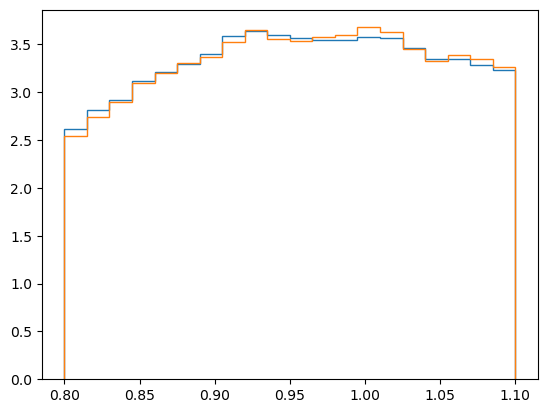

In [2]:
from abacus_hf import get_clustering_rdzw, get_data_fn, get_randoms_fn

fn = get_data_fn(**catalog_args)
data = get_clustering_rdzw(fn, **catalog_args)
ax = plt.gca()
bins = 20
ax.hist(data[2], bins=bins, density=True, histtype='step', label='data')
fn = get_randoms_fn()
randoms = get_clustering_rdzw(fn, **catalog_args)
ax.hist(randoms[2], bins=bins, density=True, histtype='step', label='randoms')
plt.show()

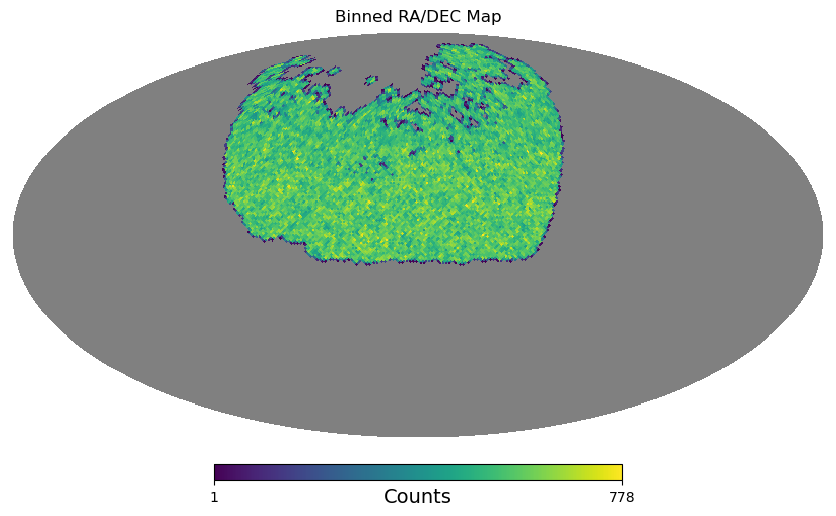

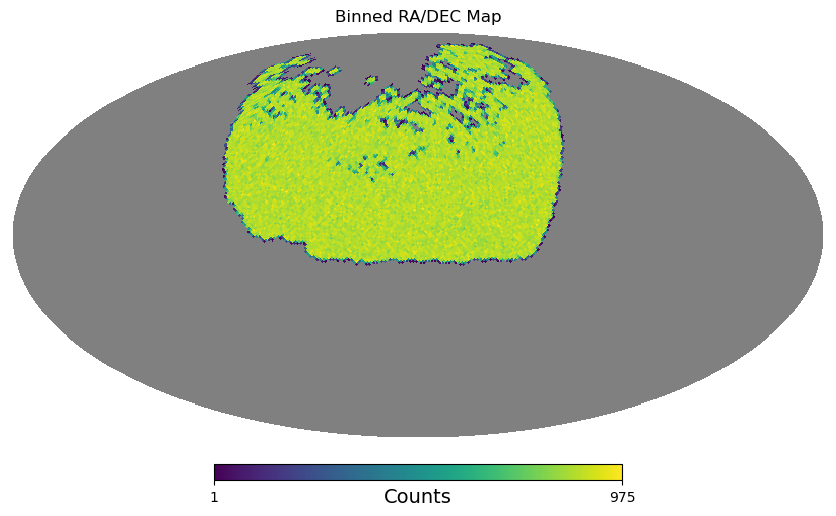

In [3]:
def plot_healpix(ra, dec, nside=64, title="Binned RA/DEC Map", show=True):
    import healpy as hp
    npix = hp.nside2npix(nside)
    # Convert to theta (colatitude) and phi (longitude) in radians
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra + 180.)
    # Get pixel indices
    pix = hp.ang2pix(nside, theta, phi)
    # Bin into HEALPix map
    healpix_map = np.bincount(pix, minlength=npix)
    # Mask unseen pixels
    healpix_map = np.where(healpix_map == 0, hp.UNSEEN, healpix_map)
    # Plot
    hp.mollview(healpix_map, title=title, unit="Counts", cmap="viridis")
    if show:
        plt.show()

plot_healpix(*data[:2])
plot_healpix(*randoms[:2])